In [4]:
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import json
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

### Loading the dinesafe data

In [7]:
datapath = r'data/'

In [8]:
dfd = pd.read_csv(datapath + 'dinesafe.csv', parse_dates=['INSPECTION_DATE']).drop('Unnamed: 0', axis=1)
dfd.head()

,ROW_ID,ESTABLISHMENT_ID,INSPECTION_ID,ESTABLISHMENT_NAME,ESTABLISHMENTTYPE,ESTABLISHMENT_ADDRESS,LATITUDE,LONGITUDE,ESTABLISHMENT_STATUS,MINIMUM_INSPECTIONS_PERYEAR,INFRACTION_DETAILS,INSPECTION_DATE,SEVERITY,ACTION,COURT_OUTCOME,AMOUNT_FINED
0,1,1222579,103868579,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash equipment,2016-12-21,M - Minor,Notice to Comply,,
1,2,1222579,104063869,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,NaN,2017-10-04,NaN,NaN,NaN,NaN
2,3,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Fail to Hold a Valid Food Handler's Certificat...,2018-06-20,NA - Not Applicable,Notice to Comply,,
3,4,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash equipment,2018-06-20,M - Minor,Notice to Comply,,
4,5,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash surfaces in rooms,2018-06-20,M - Minor,Notice to Comply,,


In [9]:
insp = dfd[['ESTABLISHMENT_ID', 'INSPECTION_DATE']].groupby('ESTABLISHMENT_ID').count().sort_values('INSPECTION_DATE', ascending=False)

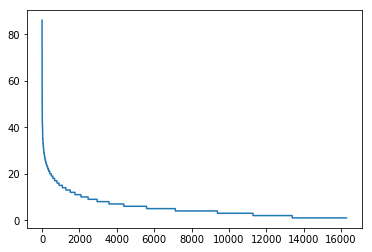

In [11]:
plt.plot(insp.values)
plt.show()

### Initial exploration

In [12]:
# Pass count
df_pass = dfd[['ESTABLISHMENT_STATUS', 'ROW_ID']].groupby('ESTABLISHMENT_STATUS').count()
df_pass['pct'] = df_pass['ROW_ID'] / df_pass['ROW_ID'].sum()
df_pass

,ROW_ID,pct
ESTABLISHMENT_STATUS,,
Closed,352,0.003889
Conditional Pass,17237,0.190422
Pass,72931,0.805689


min date: 2016-09-23
max date: 2018-09-21


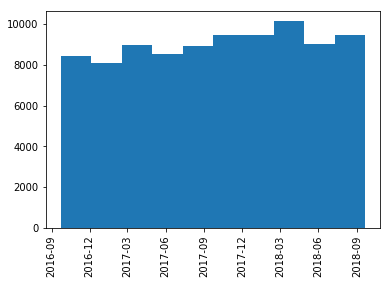

In [13]:
# time
plt.hist(dfd['INSPECTION_DATE'], bins=10)
plt.xticks(rotation='vertical')
print("min date: %s" % dfd['INSPECTION_DATE'].min().date())
print("max date: %s" % dfd['INSPECTION_DATE'].max().date())
plt.show()

In [14]:
# severity
df_severe = dfd[['SEVERITY', 'ROW_ID']].groupby('SEVERITY').count()
df_severe['pct'] = df_severe['ROW_ID'] / df_severe['ROW_ID'].sum()
df_severe

,ROW_ID,pct
SEVERITY,,
C - Crucial,2400,0.038899
M - Minor,32280,0.523194
NA - Not Applicable,4048,0.065610
S - Significant,22970,0.372297


### Fines

In [15]:
df_fined = dfd[(pd.notnull(dfd['AMOUNT_FINED'])) & (dfd['AMOUNT_FINED'] != ' ')].copy()
df_fined['COURT_OUTCOME'].unique()

array(['Conviction - Fined',
       'Conviction - Fined & Order to Close by Court',
       'Charges Withdrawn', 'Conviction - Suspended Sentence',
       'Charges Quashed'], dtype=object)

In [16]:
fine_map = {
    'Conviction - Fined': True,
    'Conviction - Fined & Order to Close by Court': True,
    'Charges Withdrawn': False, 
    'Conviction - Suspended Sentence': True,
    'Charges Quashed': False
}

In [17]:
df_fined['Convicted'] = df_fined['COURT_OUTCOME'].apply(lambda x: fine_map[x])
df_fined['dollar_amt'] = df_fined['AMOUNT_FINED'].apply(lambda x: float(x))

In [18]:
df_fined.head()

,ROW_ID,ESTABLISHMENT_ID,INSPECTION_ID,ESTABLISHMENT_NAME,ESTABLISHMENTTYPE,ESTABLISHMENT_ADDRESS,LATITUDE,LONGITUDE,ESTABLISHMENT_STATUS,MINIMUM_INSPECTIONS_PERYEAR,INFRACTION_DETAILS,INSPECTION_DATE,SEVERITY,ACTION,COURT_OUTCOME,AMOUNT_FINED,Convicted,dollar_amt
695,696,9001150,103920617,STARBUCKS,Restaurant,1088 YONGE ST,43.677997,-79.390257,Pass,1,Operate food premise - fail to keep facility s...,2017-02-28,M - Minor,Ticket,Conviction - Fined,65.00,True,65.0
853,854,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Fail to Hold a Valid Food Handler's Certificat...,2017-12-01,NA - Not Applicable,Ticket,Conviction - Fined,63.50,True,63.5
854,855,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Operate food premise - fail to keep facility s...,2017-12-01,M - Minor,Ticket,Conviction - Fined,63.50,True,63.5
855,856,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Operator fail to ensure room kept free from ma...,2017-12-01,M - Minor,Ticket,Conviction - Fined,63.50,True,63.5
858,859,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Store hazardous foods at internal temperature ...,2017-12-01,C - Crucial,Summons,Conviction - Fined,1130,True,1130.0


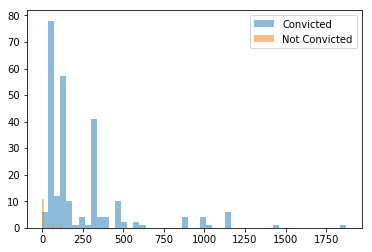

In [19]:
# any fines?
plt.hist(df_fined[df_fined['Convicted']]['dollar_amt'], alpha=0.5, label='Convicted', bins=50)
plt.hist(df_fined[~df_fined['Convicted']]['dollar_amt'], alpha=0.5, label='Not Convicted')
plt.legend()
plt.show()

### Narrowing the Yelp Dataset

In [20]:
f = open(datapath + 'yelp_academic_dataset_business.json', 'r')

buslist = []
for i, line in enumerate(f):
    buslist.append(json.loads(line))
    
dfy = pd.DataFrame(buslist).set_index(['business_id'])

In [21]:
dfy.shape

(188593, 14)

In [22]:
toronto_cities = [x for x in dfy['city'].unique() if 'toronto' in x.lower()] \
                    + [x for x in dfy['city'].unique() if 'etobi' in x.lower()] \
                    + [x for x in dfy['city'].unique() if 'miss' in x.lower()] \
                    + [x for x in dfy['city'].unique() if 'york' in x.lower()] \
                    + [x for x in dfy['city'].unique() if 'etobi' in x.lower()] \
                    + [x for x in dfy['city'].unique() if 'scar' in x.lower()]
toronto_cities

['Toronto',
 'toronto',
 'Downtown Toronto',
 'Toronto Division',
 'Toronto-North York',
 'West Toronto',
 'Toronto-West',
 'North Toronto',
 'Toronto-Etobicoke',
 'Toronto Scarborough',
 'Etobicoke',
 'Etobiicoke',
 'etobicoke',
 'Etobicoke,',
 'Etobicoke On',
 'Toronto-Etobicoke',
 'Mississauga',
 'East Mississauga',
 'Missisauga',
 'Mississauaga',
 'Mississauge',
 'Mississuaga',
 'North York',
 'East York',
 'York',
 'North  York',
 'NORTH YORK',
 'Yorkdale',
 'NorthYork',
 'Toronto-North York',
 'York Regional Municipality',
 'Regional Municipality of York',
 'Etobicoke',
 'Etobiicoke',
 'etobicoke',
 'Etobicoke,',
 'Etobicoke On',
 'Toronto-Etobicoke',
 'Scarborough',
 'Scarbrough',
 'SCARBOROUGH',
 'Scarborough,',
 'Scarobrough',
 'Scarborough (C)',
 'Toronto Scarborough']

In [48]:
df_toronto = dfy[(dfy['city'].isin(toronto_cities)) & (dfy['state'] == 'ON')].copy()
df_toronto.shape

(24453, 14)

In [49]:
df_toronto['postal_prefix'] = df_toronto['postal_code'].apply(lambda x: x[:2])
df_toronto['postal_prefix'].unique()

array(['M6', 'L4', 'M5', 'L5', 'M1', 'M3', 'M8', 'M4', 'M2', 'M9', 'M7',
       '', 'V0', 'L3', 'L1', 'L6', 'P0', 'W8', 'K0', 'V5'], dtype=object)

### Filter by Long Lat

In [63]:
LOC_BOUND_UP = 99
LOC_BOUND_DOWN = 1

In [64]:
print(np.percentile(df_toronto['latitude'].dropna(), LOC_BOUND_UP))
print(np.percentile(df_toronto['latitude'].dropna(), LOC_BOUND_DOWN))

43.817079277
43.53173785204


In [65]:
print(np.percentile(df_toronto['longitude'].dropna(), LOC_BOUND_UP))
print(np.percentile(df_toronto['longitude'].dropna(), LOC_BOUND_DOWN))

-79.222304296408
-79.73559971


#### Clearly the bounds are pretty tight, we will drop anything outside of the bounds

In [68]:
print("before:", df_toronto.shape)
df_ll = df_toronto[(df_toronto['latitude'] <= np.percentile(df_toronto['latitude'].dropna(), LOC_BOUND_UP)) &
                   (df_toronto['latitude'] >= np.percentile(df_toronto['latitude'].dropna(), LOC_BOUND_DOWN)) &
                   (df_toronto['longitude'] <= np.percentile(df_toronto['longitude'].dropna(), LOC_BOUND_UP)) &
                   (df_toronto['longitude'] >= np.percentile(df_toronto['longitude'].dropna(), LOC_BOUND_DOWN))].copy()              
print("after:", df_ll.shape)

before: (24453, 15)
after: (23482, 15)


In [69]:
df_ll['postal_prefix'] = df_ll['postal_code'].apply(lambda x: x[:2])
df_ll['postal_prefix'].unique()

array(['M6', 'L4', 'M5', 'L5', 'M1', 'M3', 'M8', 'M4', 'M2', 'M9', 'M7',
       '', 'V0', 'L1', 'L6', 'W8', 'L3', 'V5'], dtype=object)

### Filter by category

In [75]:
len(df_ll['categories'].unique())
# how do we pick out the categories that are relevant?

12218

In [76]:
[x for x in df_ll['categories'].dropna().unique() if 'burger' in x.lower()]

['American (Traditional), Burgers, Fast Food, Restaurants',
 'Restaurants, Burgers',
 'Restaurants, Food Delivery Services, Food, Burgers, Chicken Wings',
 'Food, Burgers, Ice Cream & Frozen Yogurt, Restaurants',
 'Burgers, Fast Food, Restaurants, Hot Dogs',
 'Fast Food, Hot Dogs, Burgers, Restaurants',
 'Fast Food, Restaurants, Burgers',
 'Burgers, Chicken Wings, Restaurants, Canadian (New)',
 'Burgers, Poutineries, Fast Food, Canadian (New), Restaurants',
 'Restaurants, Vietnamese, Asian Fusion, Burgers',
 'American (Traditional), Fast Food, Restaurants, Burgers',
 'Burgers, Restaurants',
 'Burgers, Fast Food, Restaurants',
 'Bars, Canadian (New), Nightlife, Fast Food, Pubs, Fish & Chips, Food, Seafood, American (Traditional), Restaurants, Burgers',
 'Nightlife, Bars, Cafes, Sandwiches, Restaurants, Venues & Event Spaces, Breakfast & Brunch, Burgers, Event Planning & Services',
 'Burgers, Breakfast & Brunch, Fast Food, Restaurants',
 'Burgers, Restaurants, Fast Food',
 'Vegetarian, B

In [77]:
keywords = [
    'food',
    'restaurant',
    'bar',
    'soup',
    'sushi',
    'seafood',
    'cafe',
    'diner',
    'steak',
    'burger'
]

# build large list of lists
all_list = []
for kw in keywords:
    all_list.append([x for x in df_ll['categories'].dropna().unique() if kw in x.lower()])

# merge list of lists
master_list = []
for sublist in all_list:
    for item in sublist:
        if item not in master_list:
            master_list.append(item)
len(master_list)

6602

In [78]:
dft = df_ll[df_ll['categories'].isin(master_list)].copy()
dft.head()

,address,attributes,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,postal_prefix
business_id,,,,,,,,,,,,,,,
9A2quhZLyWk0akUetBd8hQ,631 Bloor St W,"{'RestaurantsPriceRange2': '1', 'BusinessParki...","Food, Bakeries",Toronto,None,0,43.664378,-79.414424,Bnc Cake House,Koreatown,M6G 1K8,7,4.0,ON,M6
6OuOZAok8ikONMS_T3EzXg,"3417 Derry Road E, Unit 103","{'RestaurantsGoodForGroups': 'True', 'Restaura...","Restaurants, Thai",Mississauga,None,1,43.712946,-79.632763,Thai One On,Ridgewood,L4T 1A8,7,2.0,ON,L4
tZnSodhPwNr4bzrwJ1CSbw,595 Markham Street,"{'WheelchairAccessible': 'False', 'Restaurants...","Cajun/Creole, Southern, Restaurants",Toronto,"{'Tuesday': '17:0-1:0', 'Friday': '17:0-1:0', ...",0,43.664125,-79.411886,Southern Accent Restaurant,Palmerston,M6G 2L7,146,4.0,ON,M6
5J3b7j3Fzo9ISjChmoUoUA,746 Street Clair Avenue W,"{'BikeParking': 'True', 'OutdoorSeating': 'Fal...","Food, Bakeries, Coffee & Tea",Toronto,"{'Monday': '7:30-19:0', 'Tuesday': '7:30-19:0'...",1,43.681328,-79.427884,Mabel's Bakery,Wychwood,M6C 1B5,23,4.0,ON,M6
PMDlKLd0Mxj0ngCpuUmE5Q,99 Yorkville Avenue,"{'RestaurantsReservations': 'False', 'OutdoorS...","Restaurants, Food, Canadian (New), Coffee & Tea",Toronto,None,0,43.670885,-79.392379,The Coffee Mill Restaurant,Yorkville,M5R 3K5,25,3.5,ON,M5


In [79]:
dft.shape

(13140, 15)

In [80]:
dft.to_pickle('results/rest_univ.p')

### Joining

In [ ]:
dfd = dfd.set_index('ROW_ID')

In [ ]:
# converting all to lower case
dfd['name'] = dfd['ESTABLISHMENT_NAME'].apply(lambda x: x.lower())
dfd['address'] = dfd['ESTABLISHMENT_ADDRESS'].apply(lambda x: x.lower())
dft['name'] = dft['name'].apply(lambda x: x.lower())
dft['address'] = dft['address'].apply(lambda x: x.lower())

display(dfd[:1][['name', 'address']])
print(dfd.shape)

display(dft[:1][['name', 'address']])
print(dft.shape)

In [ ]:
dfd.columns

In [ ]:
# required combined address and name match score
CUT_OFF_SCORE = 0.8

total_count = dft.shape[0]
final_mapper = {}
for i, row in enumerate(dft.iterrows()):
    cur_bus_id = row[0]
    cur_name = row[1]['name']
    cur_addr = row[1]['address']
    print("processing (%s/%s) business: %s at address: %s with id: %s" % (i+1
                                                                          , total_count
                                                                          , cur_name
                                                                          , cur_addr
                                                                          , cur_bus_id))
    
    dfd['match_name'] = dfd['name'].apply(lambda x: fuzz.partial_ratio(x, cur_name))
    dfd['match_addr'] = dfd['address'].apply(lambda x: fuzz.partial_ratio(x, cur_addr))
    dfd['score'] = (dfd['match_name'] /  100) * (dfd['match_addr'] / 100)
    dfd = dfd.sort_values('score', ascending=False)
    if dfd['score'].values[0] > CUT_OFF_SCORE:
        print("\n!!! Found Match for \n(%s, %s) in the dinesafe db \n at (ROW_ID: %s, %s, %s)" % (cur_name
                                                                                       , cur_addr
                                                                                       , dfd.index[0]
                                                                                       , dfd['name'].values[0]
                                                                                       , dfd['address'].values[0]))
        final_mapper[cur_bus_id] = dfd.index[0]
    
    if i > 1000:
        break
    

In [ ]:
df_map = pd.DataFrame(final_mapper, index=['mapped_ROW_ID']).T
df_map.index.name = 'yelp_business_id'
df_map

In [ ]:
df_map.shape

In [ ]:
df_map.to_csv('mapped_res.csv')

In [ ]:
# run full data set, report reviews, restaurants, labels